# Exoplanet exploration using Machine Learning

## Computational Astrobiology: Tutorial 3

Instructor:  Andjelka B. Kovačević

28 March, 4 April 2024

Following [this notebook](https://github.com/nageshsinghc4/Exoplanet-exploration) by [nageshsinghc4](https://github.com/nageshsinghc4/).

## What are exoplanets?

Exoplanets are planets beyond our own solar system. Thousands have been discovered in the past two decades, mostly with NASA’s Kepler Space Telescope.

These exoplanets come in a huge variety of sizes and orbits. Some are gigantic planets hugging close to their parent stars; others are icy, some rocky. NASA and other agencies are looking for a special kind of planet: one that’s the same size as Earth, orbiting a sun-like star in the habitable zone.

The habitable zone is the area around a star where it is not too hot and not too cold for liquid water to exist on the surface of surrounding planets. Imagine if Earth was where Pluto is. The Sun would be barely visible (about the size of a pea) and Earth’s ocean and much of its atmosphere would freeze.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Load all the required libraries

In [2]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix, roc_curve, auc, roc_curve,accuracy_score #,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

### Load the train and test data.

We use Kepler labelled time series data  from [kaggle](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?resource=download&select=exoTrain.csv).

In [3]:
test_data = pd.read_csv('exoTest.csv')
train_data = pd.read_csv('exoTrain.csv')

In [4]:
train_data

LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0         2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1         2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2         2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3         2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4         2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   
...     ...      ...      ...      ...      ...      ...      ...     ...   
5082      1   -91.91   -92.97   -78.76   -97.33   -68.00   -68.24  -75.48   
5083      1   989.75   891.01   908.53   851.83   755.11   615.78  595.77   
5084      1   273.39   278.00   261.73   236.99   280.73   264.90  252.92   
5085      1     3.82     2.09    -3.29    -2.88     1.66    -0.75    3.85   
5086      1   323.28   306.36   293.16   287.67   249.89   218.30  188.86   

       FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0      -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1      -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2      486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3      311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4    -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   
...       ...     ...  ...        ...        ...        ...        ...   
5082   -49.25  -30.92  ...     139.95     147.26     156.95     155.64   
5083   458.87  492.84  ...     -26.50      -4.84     -76.30     -37.84   
5084   254.88  237.60  ...     -26.82     -53.89     -48.71      30.99   
5085    -0.03    3.28  ...      10.86      -3.23      -5.10      -4.61   
5086   178.93  118.93  ...      71.19       0.97      55.20      -1.63   

      FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0         48.57      92.54      39.32      61.42       5.08     -39.54  
1         -4.86       0.76     -11.70       6.46      16.00      19.93  
2        -20.88       5.06     -11.80     -28.91     -70.02     -96.67  
3         20.03     -12.67      -8.77     -17.31     -17.35      13.98  
4       -443.76    -438.54    -399.71    -384.65    -411.79    -510.54  
...         ...        ...        ...        ...        ...        ...  
5082     156.36     151.75     -24.45     -17.00       3.23      19.28  
5083    -153.83    -136.16      38.03     100.28     -45.64      35.58  
5084      15.96      -3.47      65.73      88.42      79.07      79.43  
5085      -9.82      -1.50      -4.65     -14.55      -6.41      -2.55  
5086      -5.50     -25.33     -41.31     -16.72     -14.09      27.82  

[5087 rows x 3198 columns]

Now the target column LABEL consists of two categories 1(Does not represents exoplanet) and 2(represents the presence of exoplanet). So, convert them to binary values for easier processing of data.

In [5]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [6]:
train_data.describe()

LABEL        FLUX.1        FLUX.2        FLUX.3        FLUX.4  \
count  5087.000000  5.087000e+03  5.087000e+03  5.087000e+03  5.087000e+03   
mean      0.007273  1.445054e+02  1.285778e+02  1.471348e+02  1.561512e+02   
std       0.084982  2.150669e+04  2.179717e+04  2.191309e+04  2.223366e+04   
min       0.000000 -2.278563e+05 -3.154408e+05 -2.840018e+05 -2.340069e+05   
25%       0.000000 -4.234000e+01 -3.952000e+01 -3.850500e+01 -3.505000e+01   
50%       0.000000 -7.100000e-01 -8.900000e-01 -7.400000e-01 -4.000000e-01   
75%       0.000000  4.825500e+01  4.428500e+01  4.232500e+01  3.976500e+01   
max       1.000000  1.439240e+06  1.453319e+06  1.468429e+06  1.495750e+06   

             FLUX.5        FLUX.6        FLUX.7        FLUX.8        FLUX.9  \
count  5.087000e+03  5.087000e+03  5.087000e+03  5.087000e+03  5.087000e+03   
mean   1.561477e+02  1.469646e+02  1.168380e+02  1.144983e+02  1.228639e+02   
std    2.308448e+04  2.410567e+04  2.414109e+04  2.290691e+04  2.102681e+04   
min   -4.231956e+05 -5.975521e+05 -6.724046e+05 -5.790136e+05 -3.973882e+05   
25%   -3.195500e+01 -3.338000e+01 -2.813000e+01 -2.784000e+01 -2.683500e+01   
50%   -6.100000e-01 -1.030000e+00 -8.700000e-01 -6.600000e-01 -5.600000e-01   
75%    3.975000e+01  3.514000e+01  3.406000e+01  3.170000e+01  3.045500e+01   
max    1.510937e+06  1.508152e+06  1.465743e+06  1.416827e+06  1.342888e+06   

       ...     FLUX.3188     FLUX.3189     FLUX.3190     FLUX.3191  \
count  ...  5.087000e+03  5.087000e+03  5.087000e+03  5.087000e+03   
mean   ...  3.485578e+02  4.956476e+02  6.711211e+02  7.468790e+02   
std    ...  2.864786e+04  3.551876e+04  4.349963e+04  4.981375e+04   
min    ... -3.240480e+05 -3.045540e+05 -2.933140e+05 -2.838420e+05   
25%    ... -1.760000e+01 -1.948500e+01 -1.757000e+01 -2.076000e+01   
50%    ...  2.600000e+00  2.680000e+00  3.050000e+00  3.590000e+00   
75%    ...  2.211000e+01  2.235000e+01  2.639500e+01  2.909000e+01   
max    ...  1.779338e+06  2.379227e+06  2.992070e+06  3.434973e+06   

          FLUX.3192     FLUX.3193      FLUX.3194      FLUX.3195  \
count  5.087000e+03  5.087000e+03    5087.000000    5087.000000   
mean   6.937372e+02  6.553031e+02    -494.784966    -544.594264   
std    5.087103e+04  5.339979e+04   17844.469520   17722.339334   
min   -3.288214e+05 -5.028894e+05 -775322.000000 -732006.000000   
25%   -2.226000e+01 -2.440500e+01     -26.760000     -24.065000   
50%    3.230000e+00  3.500000e+00      -0.680000       0.360000   
75%    2.780000e+01  3.085500e+01      18.175000      18.770000   
max    3.481220e+06  3.616292e+06  288607.500000  215972.000000   

           FLUX.3196      FLUX.3197  
count    5087.000000    5087.000000  
mean     -440.239100    -300.536399  
std     16273.406292   14459.795577  
min   -700992.000000 -643170.000000  
25%       -21.135000     -19.820000  
50%         0.900000       1.430000  
75%        19.465000      20.280000  
max    207590.000000  211302.000000  

[8 rows x 3198 columns]

Now visualize the target column in the `train_data` and get an idea about the class distribution.

In [7]:
train_data['LABEL'].value_counts()

LABEL
0    5050
1      37
Name: count, dtype: int64

In [8]:
train_data['LABEL']

0       1
1       1
2       1
3       1
4       1
       ..
5082    0
5083    0
5084    0
5085    0
5086    0
Name: LABEL, Length: 5087, dtype: int64

We have 5050 records of non-exoplanets and 37 records of exoplanets.

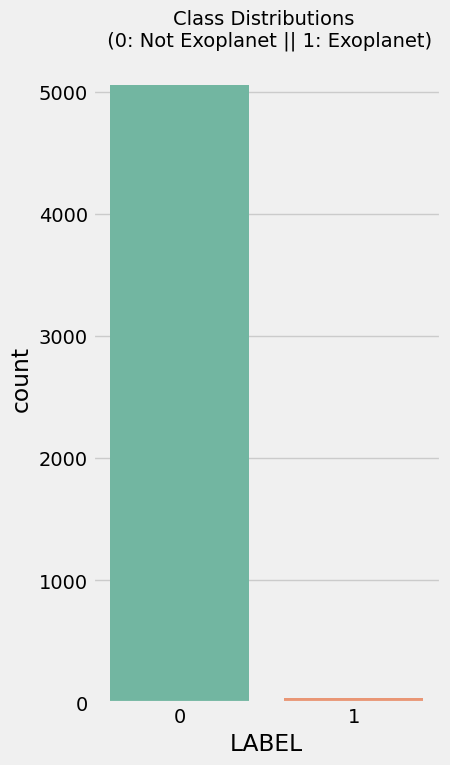

In [9]:
fig = plt.figure(figsize=(4,8))
colors = ["0", "1"]
sns.countplot(data=train_data, x='LABEL', palette = "Set2")
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)

fig.savefig('Figures\Fig1_Class_distributions.png')

It turns out that the data is highly imbalanced so later on we'll be using some sampling techniques to balance the data.

### Plotting heatmap of missing values

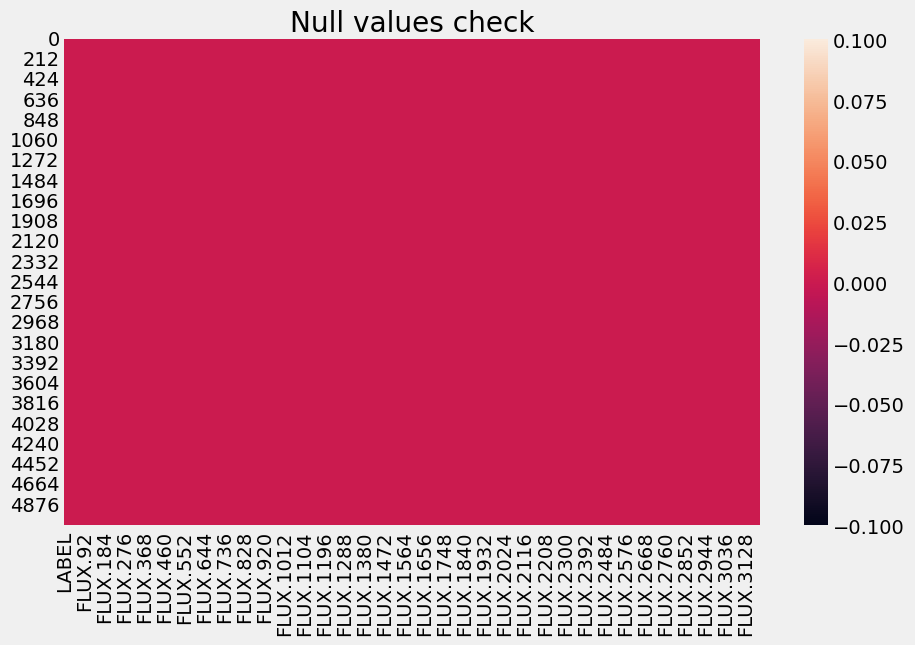

In [10]:
sns.heatmap(train_data.isnull())
plt.title('Null values check')
fig.savefig('Figures\Fig2_Null_check.png')

We can clearly see that we dont have any missing values in our dataset.

**Flux :** the intensity of light recived from a planet

### Let us plot the first 4 rows of the train data and observe the intensity of flux values.

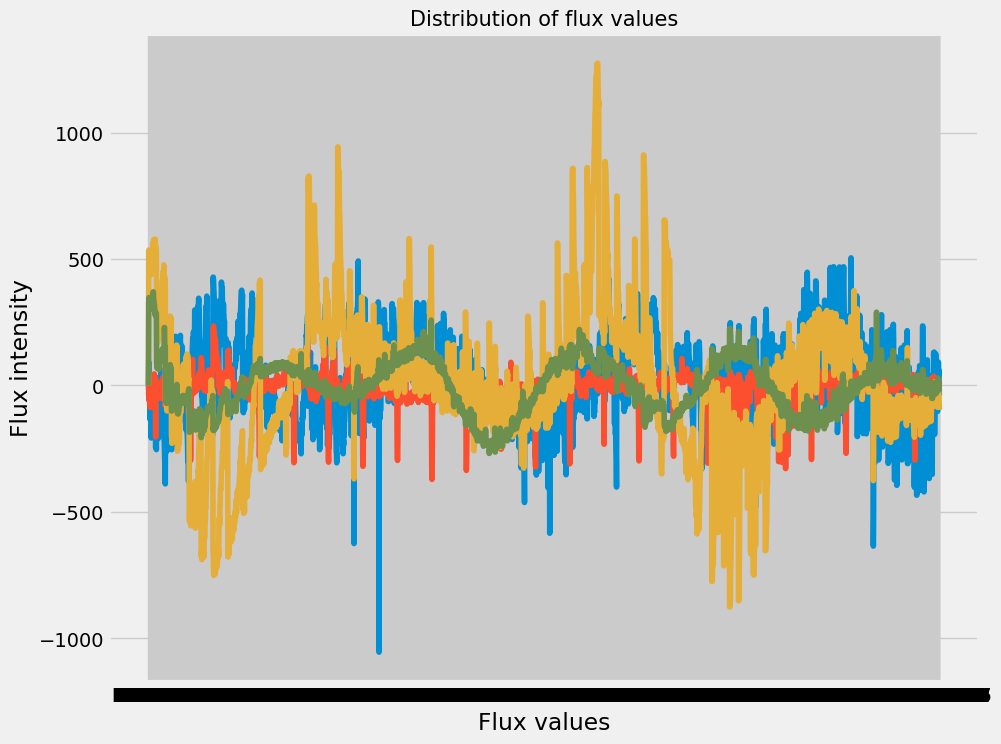

In [11]:
fig = plt.figure(figsize=(10,8))
plt.title('Distribution of flux values', fontsize=15)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

fig.savefig('Figures\Fig3_Distribution_of_flux.png')

### Plotting the correlation matrix

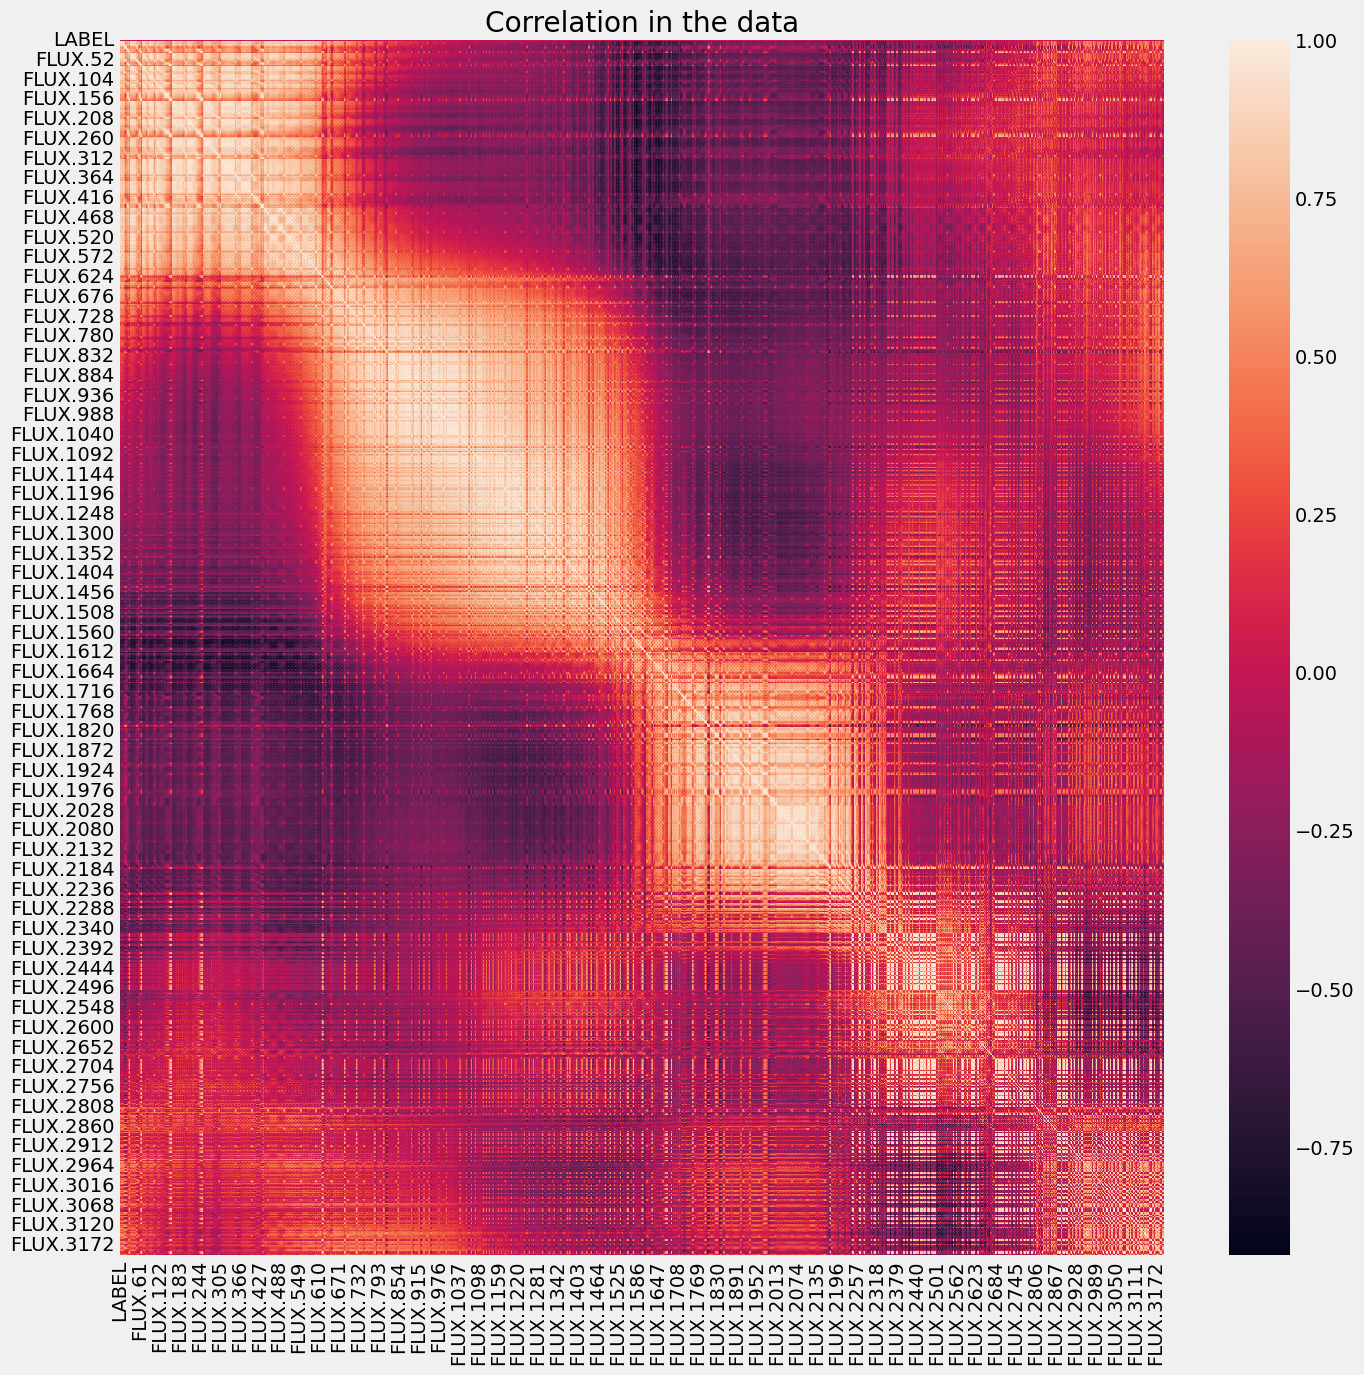

In [12]:
fig=plt.figure(figsize=(15,15))
sns.heatmap(train_data.corr())
plt.title('Correlation in the data')
plt.show()
fig.savefig('Figures\Fig4_Data_correlation.png')

### Plot the Gaussian histogram of non-exoplanetary data.

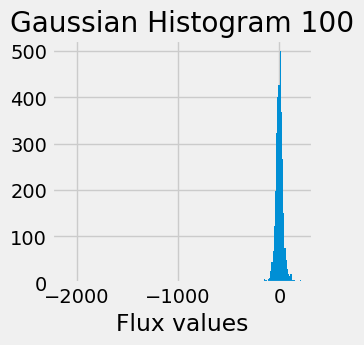

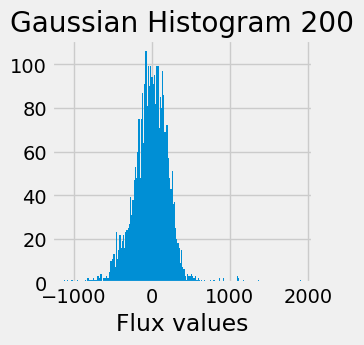

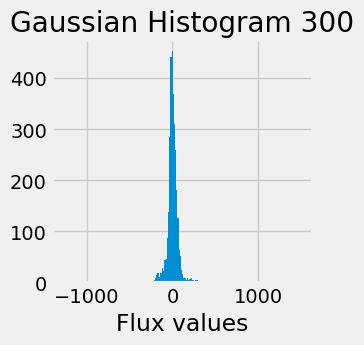

In [13]:
labels_1=[100,200,300]
for i in labels_1:
    fig=plt.figure(figsize=(3,3))
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram "+str(i))
    plt.xlabel("Flux values")
    fig.savefig('Figures\Fig5_Gaussian_hist_'+str(i)+'.png', bbox_inches='tight')
    plt.show()

### Plot Gaussian histogram of the data when exoplanets are present.

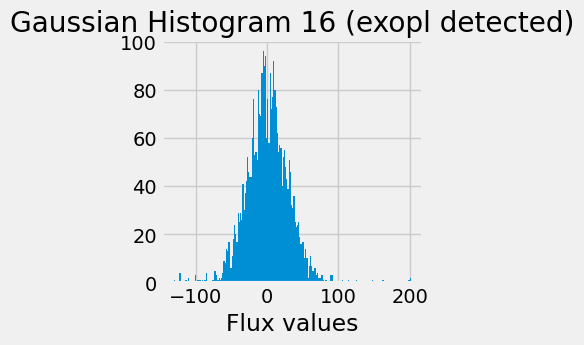

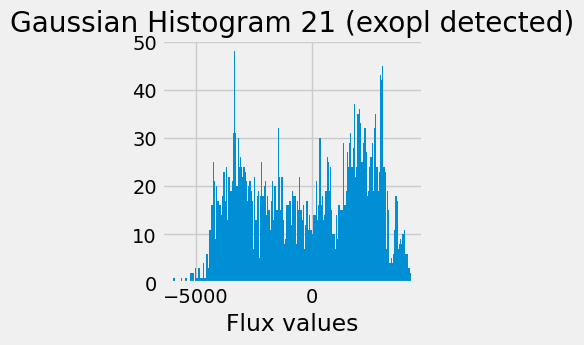

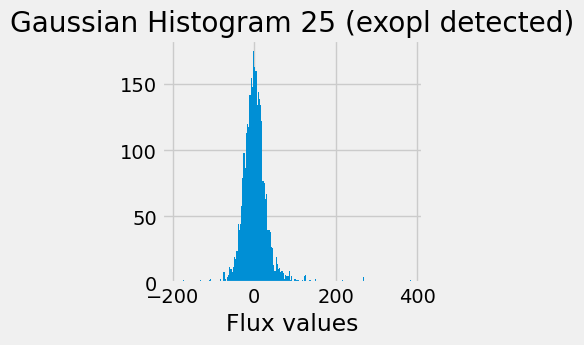

In [14]:
labels_1=[16,21,25]
for i in labels_1:
    fig=plt.figure(figsize=(3,3))
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram "+str(i)+ ' (exopl detected)')
    plt.xlabel("Flux values")
    plt.savefig('Figures\Fig6_Exo_Gaussian_hist_'+str(i)+'.png', bbox_inches='tight')
    plt.show()

### Detecting outliers using Boxplot

Box Plot is the visual representation of the depicting groups of numerical data through their quartiles. Boxplot is also used for detecting the outlier in a data set. It captures the summary of the data efficiently with a simple box and whiskers and allows us to compare easily across groups. Boxplot summarizes a sample data using 25th, 50th and 75th percentiles.

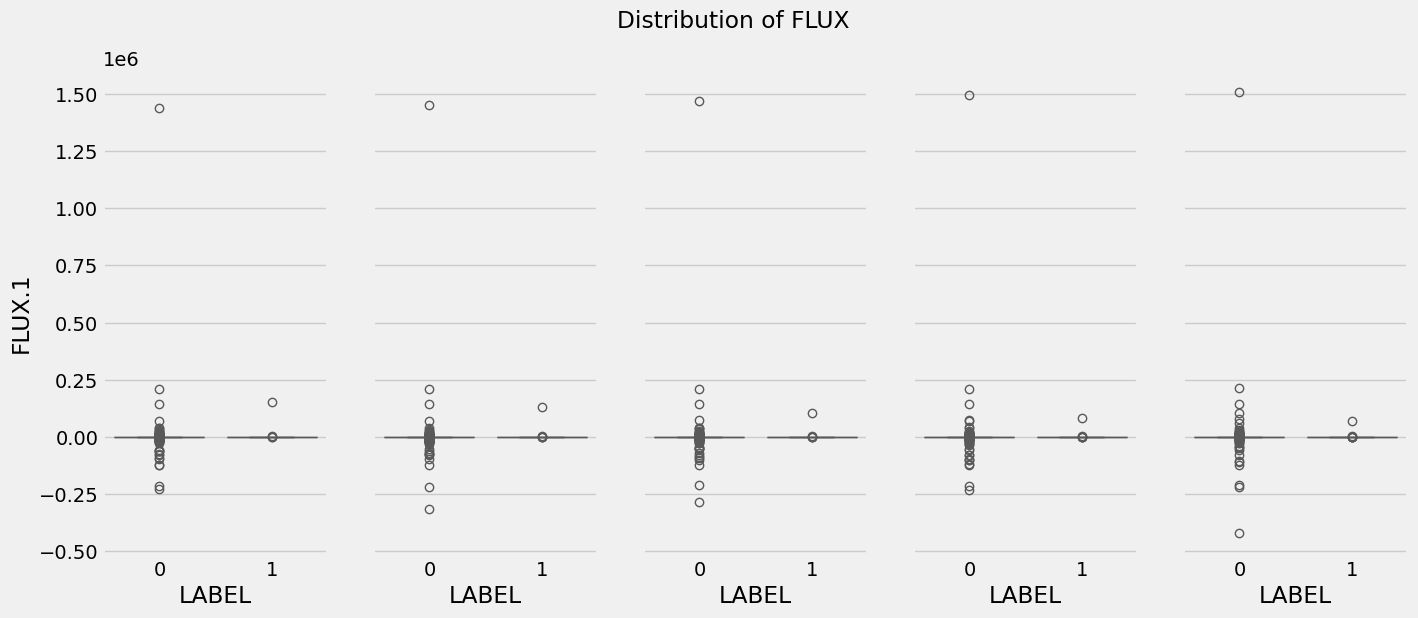

In [15]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.5',palette="Set2")

fig.savefig('Figures\Fig7_Box_plot.png', bbox_inches='tight')

Any points above 0.25e6 are considered to be outliers and are dropped from the training dataset.

In [16]:
print('Dropping Outliers')
train_data.drop(train_data[train_data['FLUX.1']>250000].index, axis=0, inplace=True)

Dropping Outliers


### Split the dataset

So let us first split our dataset and normalize it.

In [17]:
#split x and y part of the dataset
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

### Data Normalization

**Data Normalization** is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

In [18]:
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

### Apply gaussian filters

The next step is to apply gaussian filters to both test and train.


In probability theory, the normal (or Gaussian or Gauss or Laplace–Gauss) distribution is a very common continuous probability distribution. Normal distributions are important in statistics and are often used in the natural and social sciences to represent real-valued random variables whose distributions are not known.

In [19]:
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

### Feature scaling

we use feature scaling so that all the values remain in the comparable range.

In [20]:
#Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

### Model Building

In [21]:
from sklearn.neighbors import KNeighborsClassifier

Validation accuracy of KNN is 0.9912280701754386

Classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



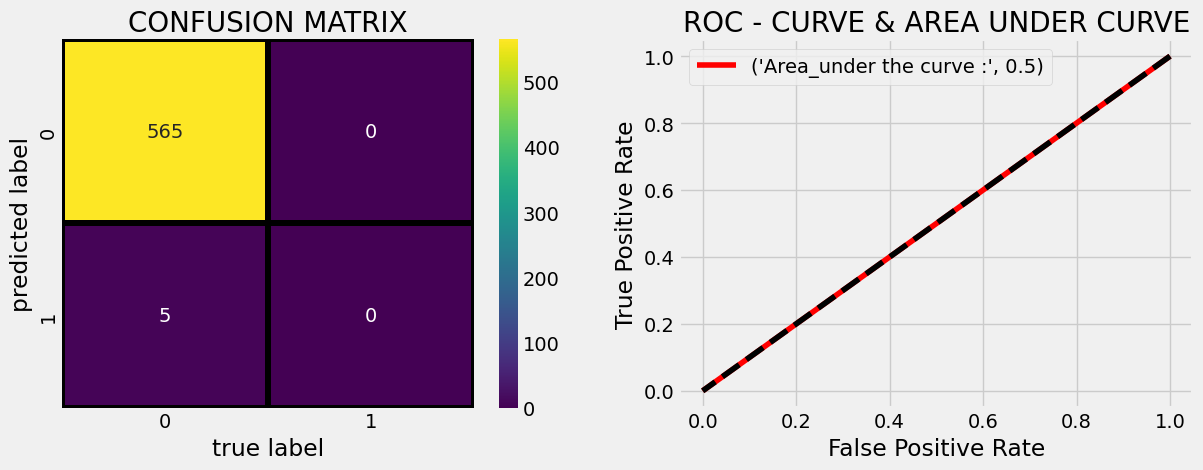

In [22]:
#K-NN
knn_model = KNeighborsClassifier()

knn_model.fit(x_train,y_train)
prediction=knn_model.predict(x_test)
print('Validation accuracy of KNN is', accuracy_score(prediction,y_test))
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
fig=plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
plt.xlabel('true label')
plt.ylabel('predicted label')

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig8_KNN_confusion_ROCcurve.png', bbox_inches='tight')

Notice that almost all predictions were the same (0) due to imbalance of the dataset.

In [23]:
from sklearn.linear_model import LogisticRegression

Validation accuracy of Logistic Regression is 0.9859649122807017

Classification report :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.98       570



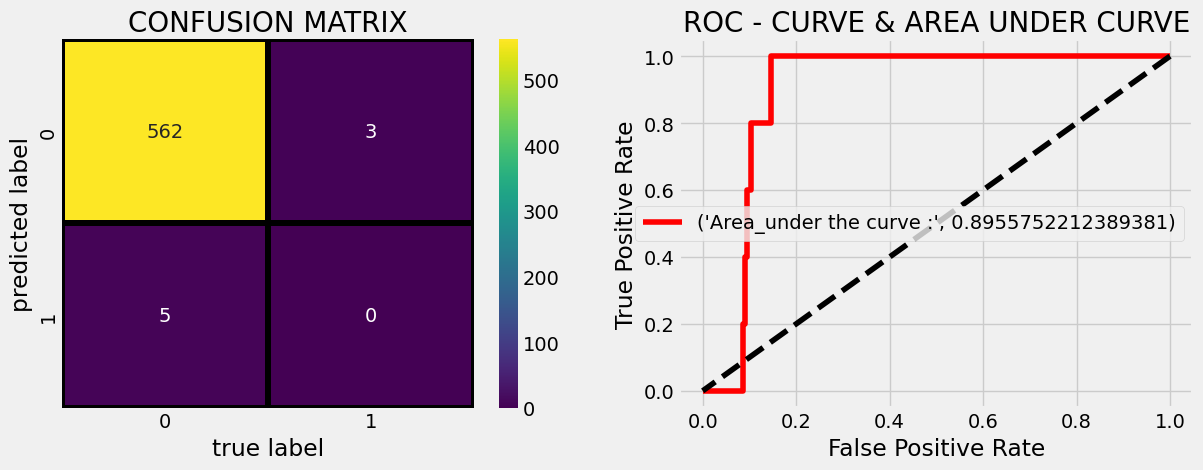

In [24]:
#Logistic Regression
lr_model = LogisticRegression(class_weight={0:100, 1:1})

lr_model.fit(x_train,y_train)

prediction=lr_model.predict(x_test)

print('Validation accuracy of Logistic Regression is', accuracy_score(prediction,y_test))
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
plt.xlabel('true label')
plt.ylabel('predicted label')

#ROC curve and Area under the curve plotting
predicting_probabilites = lr_model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig9_LR_confusion_ROCcurve.png', bbox_inches='tight')

In [25]:
from sklearn.tree import DecisionTreeClassifier

Validation accuracy of Decision Tree is 0.9614035087719298

Classification report :
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       565
           1       0.00      0.00      0.00         5

    accuracy                           0.96       570
   macro avg       0.50      0.48      0.49       570
weighted avg       0.98      0.96      0.97       570



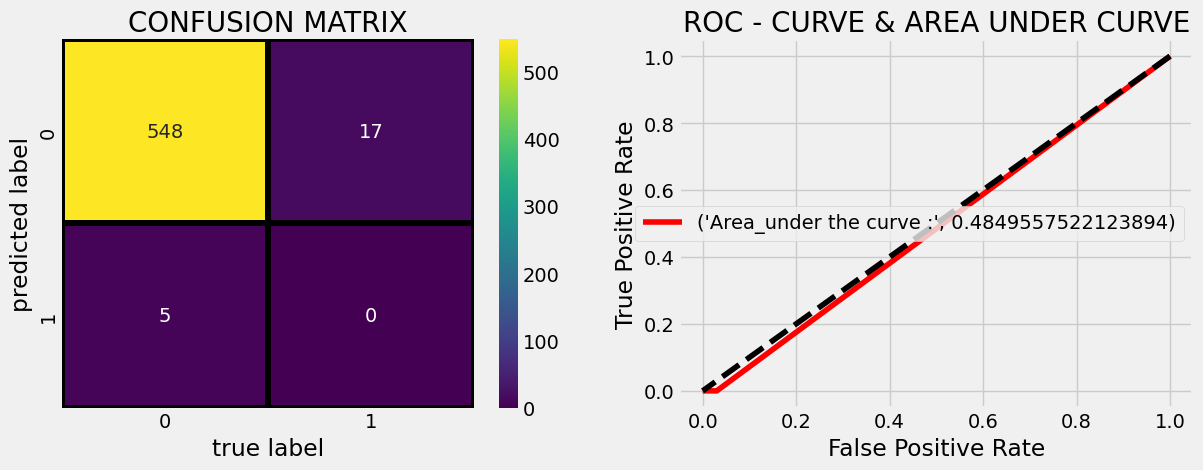

In [26]:
#Decision Tree
ds_model = DecisionTreeClassifier(max_depth=5, random_state=13)

ds_model.fit(x_train,y_train)

prediction=ds_model.predict(x_test)

print('Validation accuracy of Decision Tree is', accuracy_score(prediction,y_test))
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
plt.xlabel('true label')
plt.ylabel('predicted label')

#ROC curve and Area under the curve plotting
predicting_probabilites = ds_model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig10_DT_confusion_ROCcurve.png', bbox_inches='tight')

Since the dataset is highly imbalanced, even if the model predicts the same class for all data points the accuracy.

So let us first balance the classes and model it again.

### Balancing the class using SMOTE

**SMOTE** **(synthetic minority oversampling technique)** is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. **SMOTE** synthesises new minority instances between existing minority instances.

In [29]:
from imblearn.over_sampling import SMOTE

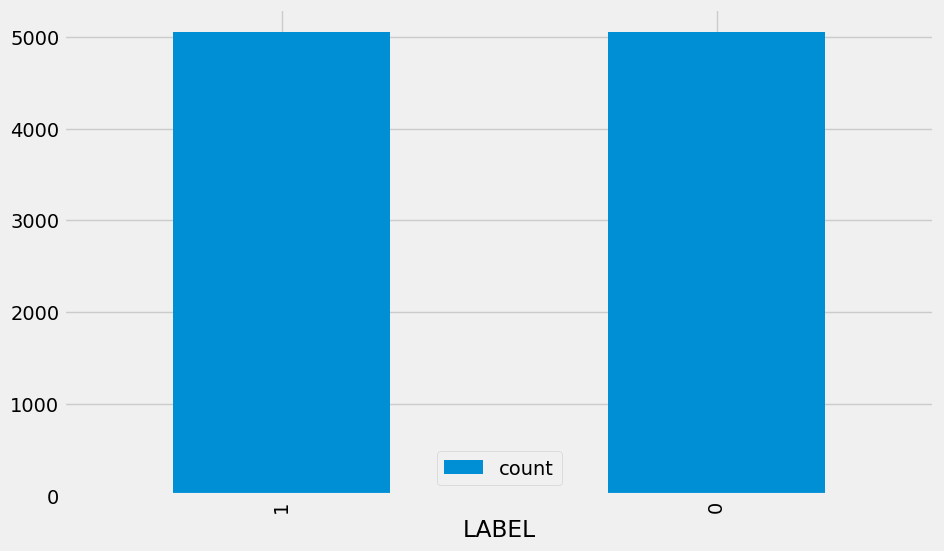

In [30]:
model = SMOTE()
ov_train_x,ov_train_y = model.fit_resample(train_data.drop('LABEL',axis=1), train_data['LABEL'])
ov_train_y = ov_train_y.astype('int')

ov_train_y.value_counts().reset_index().plot(kind='bar', x='LABEL', y='count', use_index=True)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig11_SMOTE_resampling.png', bbox_inches='tight')

Resampling has made the data balanced between the two categories.

### Split the dataset

In [31]:
train_X, test_X, train_y, test_y = train_test_split(ov_train_x, ov_train_y, test_size=0.33, random_state=42)

In [32]:
from sklearn.tree import DecisionTreeClassifier

Validation accuracy of Decision Tree is 0.9165916591659166

Classification report :
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1709
           1       0.86      0.99      0.92      1624

    accuracy                           0.92      3333
   macro avg       0.92      0.92      0.92      3333
weighted avg       0.93      0.92      0.92      3333



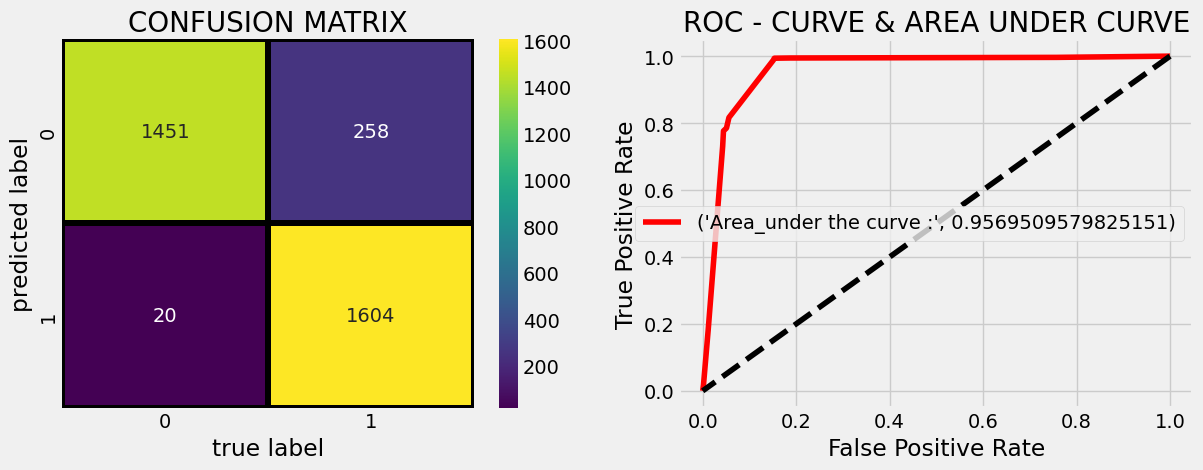

In [33]:
ds_model = DecisionTreeClassifier(max_depth=5, random_state=13)

ds_model.fit(train_X,train_y)

prediction=ds_model.predict(test_X)

print('Validation accuracy of Decision Tree is', accuracy_score(prediction,test_y))
print ("\nClassification report :\n",(classification_report(test_y,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
plt.xlabel('true label')
plt.ylabel('predicted label')

#ROC curve and Area under the curve plotting
predicting_probabilites = ds_model.predict_proba(test_X)[:,1]
fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig12_SMOTE_DT_confusion_ROCcurve.png', bbox_inches='tight')

Validation accuracy of KNN is 0.9825982598259826

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1709
           1       0.97      1.00      0.98      1624

    accuracy                           0.98      3333
   macro avg       0.98      0.98      0.98      3333
weighted avg       0.98      0.98      0.98      3333



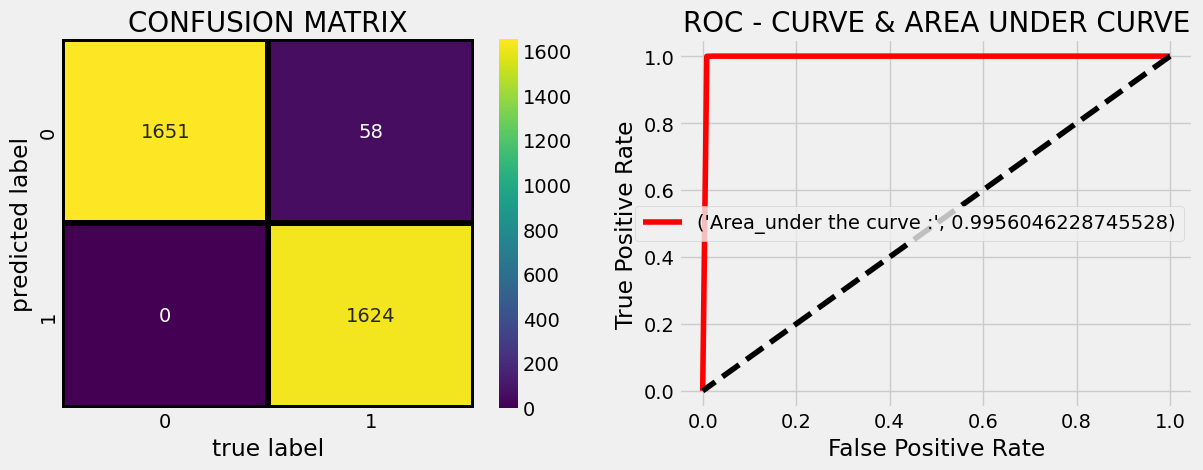

In [34]:
knn_model = KNeighborsClassifier()

knn_model.fit(train_X,train_y)

prediction=knn_model.predict(test_X)

print('Validation accuracy of KNN is', accuracy_score(prediction,test_y))
print ("\nClassification report :\n",(classification_report(test_y,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
plt.xlabel('true label')
plt.ylabel('predicted label')

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(test_X)[:,1]
fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig12_SMOTE_KNN_confusion_ROCcurve.png', bbox_inches='tight')

Validation accuracy of Logistic Regression is 0.7458745874587459

Classification report :
               precision    recall  f1-score   support

           0       0.79      0.68      0.73      1709
           1       0.71      0.81      0.76      1624

    accuracy                           0.75      3333
   macro avg       0.75      0.75      0.75      3333
weighted avg       0.75      0.75      0.75      3333



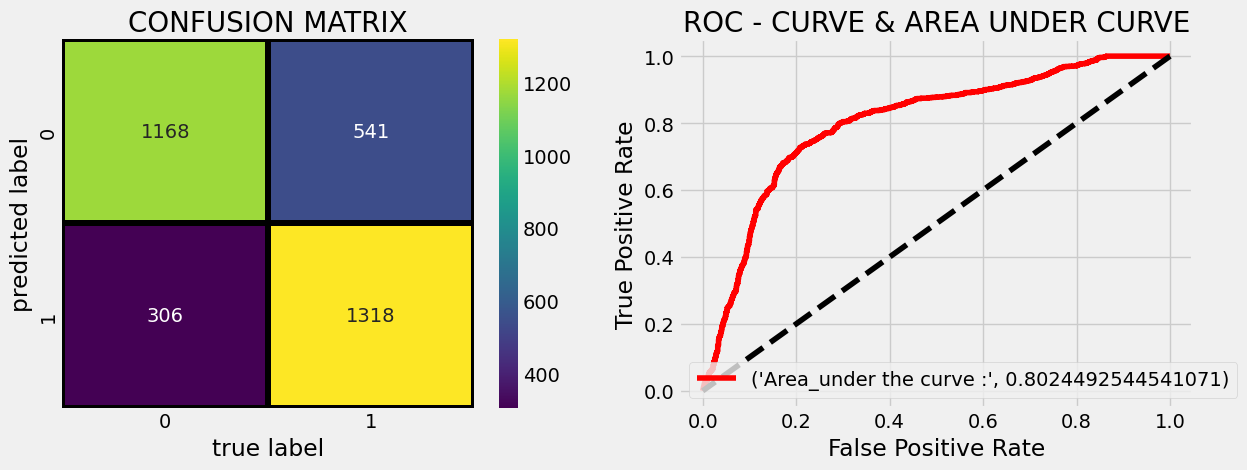

In [35]:
lr_model = LogisticRegression(class_weight={0:100, 1:1})

lr_model.fit(train_X,train_y)

prediction=lr_model.predict(test_X)

print('Validation accuracy of Logistic Regression is', accuracy_score(prediction,test_y))
print ("\nClassification report :\n",(classification_report(test_y,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
plt.xlabel('true label')
plt.ylabel('predicted label')

#ROC curve and Area under the curve plotting
predicting_probabilites = lr_model.predict_proba(test_X)[:,1]
fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig12_SMOTE_LR_confusion_ROCcurve.png', bbox_inches='tight')

As we can observe after applying SMOTE to balance the classes, our ML models are performing really good.

# Use resampling on exoplanet data

In [36]:
#import the necessary packages
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [37]:
df = pd.read_csv('LIFEsim_data.csv', index_col=0)

df

radius_p      p_orb   mass_p  ecc_p    inc_p  large_omega_p  \
0       2.55899    1.21237  6.46922    0.0  0.36825        0.83082   
1       1.62557   95.32925  2.94136    0.0  0.36825        4.71701   
2       0.64641  413.44526  0.18259    0.0  0.36825        3.59078   
3       1.45874   51.20469  5.36760    0.0  2.01016        2.62388   
4       2.03712   98.57858  4.45356    0.0  2.01016        1.71757   
...         ...        ...      ...    ...      ...            ...   
13999   0.82089   48.64809  3.00300    0.0  1.36699        3.29171   
14000   0.76631    3.78368  0.47407    0.0  2.15206        1.81751   
14001   1.29841   30.83798  1.36537    0.0  2.15206        5.07573   
14002   1.31487  184.70674  1.57873    0.0  2.15206        4.52980   
14003   0.58477  435.93984  0.21112    0.0  2.15206        5.56653   

       small_omega_p  theta_p  albedo_bond  albedo_geom_vis  ...     hz_in  \
0            4.28658  0.46104      0.07323          0.11134  ...  0.745910   
1            0.58424  3.76621      0.17084          0.46161  ...  0.745910   
2            0.90651  0.27668      0.54602          0.17279  ...  0.745910   
3            0.47298  2.25944      0.53153          0.47091  ...  0.745910   
4            2.04617  2.98199      0.32327          0.59087  ...  0.745910   
...              ...      ...          ...              ...  ...       ...   
13999        5.84907  1.15447      0.47915          0.40514  ...  0.057153   
14000        2.27749  6.06507      0.36787          0.07721  ...  0.057153   
14001        5.95634  4.86269      0.54785          0.21281  ...  0.057153   
14002        5.85123  2.65320      0.54567          0.19618  ...  0.057153   
14003        1.75524  2.02167      0.23991          0.48055  ...  0.057153   

         hz_out  hz_center  habitable    snr_1h   baseline  detected  \
0      1.746354   1.246132      False  3.747645   21.85221      True   
1      1.746354   1.246132      False  2.570891   21.85221      True   
2      1.746354   1.246132       True  0.051327   21.85221     False   
3      1.746354   1.246132      False  8.482665   21.85221      True   
4      1.746354   1.246132      False  7.213424   21.85221      True   
...         ...        ...        ...       ...        ...       ...   
13999  0.151491   0.104322       True  0.286335  100.00000     False   
14000  0.151491   0.104322      False  1.669327  100.00000     False   
14001  0.151491   0.104322       True  0.552908  100.00000     False   
14002  0.151491   0.104322      False  0.024031  100.00000     False   
14003  0.151491   0.104322      False  0.001203  100.00000     False   

       snr_current      int_time   t_slew  
0        11.808785  35743.408285      0.0  
1         8.100845  35743.408285      0.0  
2         0.161731  35743.408285      0.0  
3        26.728775  35743.408285      0.0  
4        22.729412  35743.408285      0.0  
...            ...           ...      ...  
13999     0.000000      0.000000 -36000.0  
14000     0.000000      0.000000 -36000.0  
14001     0.000000      0.000000 -36000.0  
14002     0.000000      0.000000 -36000.0  
14003     0.000000      0.000000 -36000.0  

[14004 rows x 45 columns]

In [38]:
df.columns

Index(['radius_p', 'p_orb', 'mass_p', 'ecc_p', 'inc_p', 'large_omega_p',
       'small_omega_p', 'theta_p', 'albedo_bond', 'albedo_geom_vis',
       'albedo_geom_mir', 'z', 'semimajor_p', 'sep_p', 'angsep', 'maxangsep',
       'flux_p', 'fp', 'temp_p', 'radius_s', 'mass_s', 'temp_s', 'distance_s',
       'ra', 'dec', 'nuniverse', 'nstar', 'stype', 'id', 'name_s', 'lon',
       'lat', 's_in', 's_out', 'l_sun', 'hz_in', 'hz_out', 'hz_center',
       'habitable', 'snr_1h', 'baseline', 'detected', 'snr_current',
       'int_time', 't_slew'],
      dtype='object')

In [39]:
#convert the data type which is notfloat
notfloat=df.columns[(df.dtypes.values != np.dtype('float64'))]
for i in range(len(notfloat)):
    df[notfloat[i]] = df[notfloat[i]].astype('category').cat.codes
print(notfloat)

Index(['nuniverse', 'nstar', 'stype', 'id', 'habitable', 'detected'], dtype='object')


In [40]:
#also remove columns with NaN values
df=df.drop(columns='name_s')

nan_mask = df.isna()
print(nan_mask.sum())

radius_p           0
p_orb              0
mass_p             0
ecc_p              0
inc_p              0
large_omega_p      0
small_omega_p      0
theta_p            0
albedo_bond        0
albedo_geom_vis    0
albedo_geom_mir    0
z                  0
semimajor_p        0
sep_p              0
angsep             0
maxangsep          0
flux_p             0
fp                 0
temp_p             0
radius_s           0
mass_s             0
temp_s             0
distance_s         0
ra                 0
dec                0
nuniverse          0
nstar              0
stype              0
id                 0
lon                0
lat                0
s_in               0
s_out              0
l_sun              0
hz_in              0
hz_out             0
hz_center          0
habitable          0
snr_1h             0
baseline           0
detected           0
snr_current        0
int_time           0
t_slew             0
dtype: int64


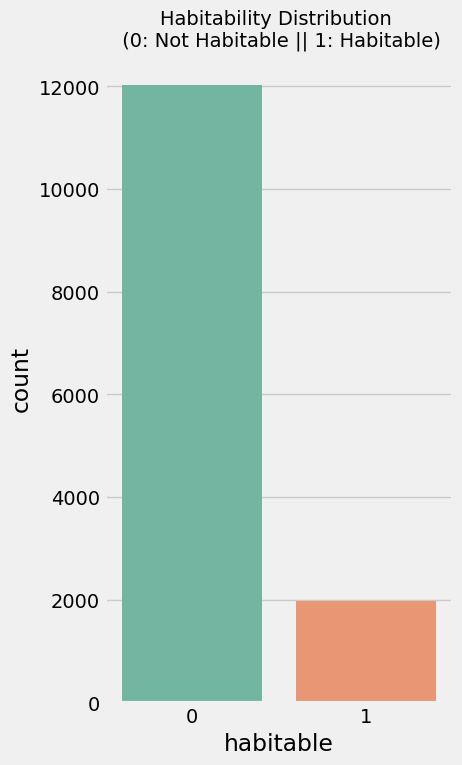

In [41]:
fig = plt.figure(figsize=(4,8))
sns.countplot(data=df, x='habitable', palette = "Set2")
plt.title('Habitability Distribution \n (0: Not Habitable || 1: Habitable)', fontsize=14)
fig.savefig('Figures\Fig13_Habitability_distribution.png')

It is clear that the data is imbalanced. There are many more unhabitable planets than habitable ones. To resolve this issue, we will oversample the dataset.

In [42]:
#splitting the data in half
training = df.loc[: len(df)/2-1]
test = df.loc[len(df)/2: ]

# output values to check df was split correctly
print(len(training),len(test), len(training)+len(test))

7002 7002 14004


Let us compare the performance of a K-Nearest Neighbour ML model on this data before and after oversampling using SMOTE.

## Before oversampling

In [43]:
#split x and y part of the dataset
x_train = training.drop(["habitable"],axis=1)
y_train = training["habitable"]
x_test = test.drop(["habitable"],axis=1)
y_test = test["habitable"]

In [44]:
#data normalization
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

In [45]:
#apply gaussian filters
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

In [46]:
#Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

Validation accuracy of KNN is 0.8331905169951442

Classification report :
               precision    recall  f1-score   support

           0       0.85      0.97      0.91      5952
           1       0.18      0.03      0.06      1050

    accuracy                           0.83      7002
   macro avg       0.52      0.50      0.48      7002
weighted avg       0.75      0.83      0.78      7002



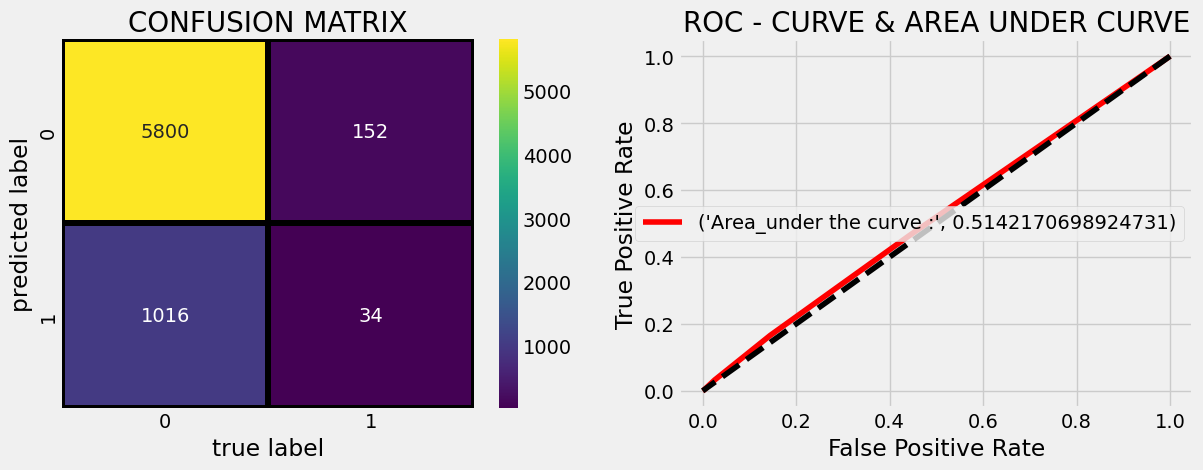

In [47]:
#K-NN
knn_model = KNeighborsClassifier()

knn_model.fit(x_train,y_train)
prediction=knn_model.predict(x_test)
print('Validation accuracy of KNN is', accuracy_score(prediction,y_test))
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
fig=plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
plt.xlabel('true label')
plt.ylabel('predicted label')

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig14_exo_KNN_confusion_ROCcurve.png', bbox_inches='tight')

The model has a hard time classifying unhabitable (0) planets, often mistakenly predicting them to be habitable (1).

## After oversampling

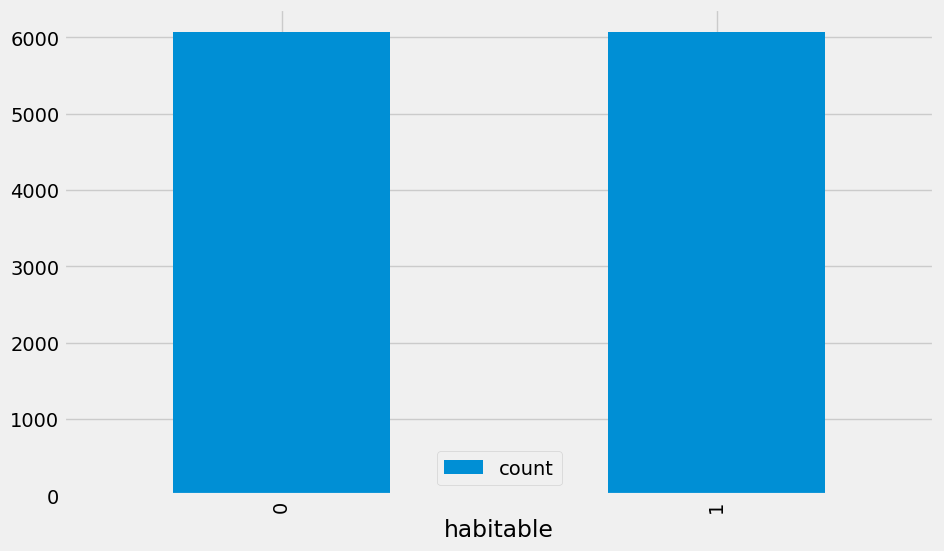

In [48]:
#oversample the data
model = SMOTE()
ov_train_x,ov_train_y = model.fit_resample(training.drop('habitable',axis=1), training['habitable'])
ov_train_y = ov_train_y.astype('int')

ov_train_y.value_counts().reset_index().plot(kind='bar', x='habitable', y='count', use_index=True)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig15_exo_SMOTE_resampling.png', bbox_inches='tight')

After oversampling, the data is balanced.

In [49]:
#split the dataset
train_X, test_X, train_y, test_y = train_test_split(ov_train_x, ov_train_y, test_size=0.33, random_state=42)

Validation accuracy of KNN is 0.8764044943820225

Classification report :
               precision    recall  f1-score   support

           0       0.95      0.80      0.87      2041
           1       0.82      0.96      0.88      1964

    accuracy                           0.88      4005
   macro avg       0.89      0.88      0.88      4005
weighted avg       0.89      0.88      0.88      4005



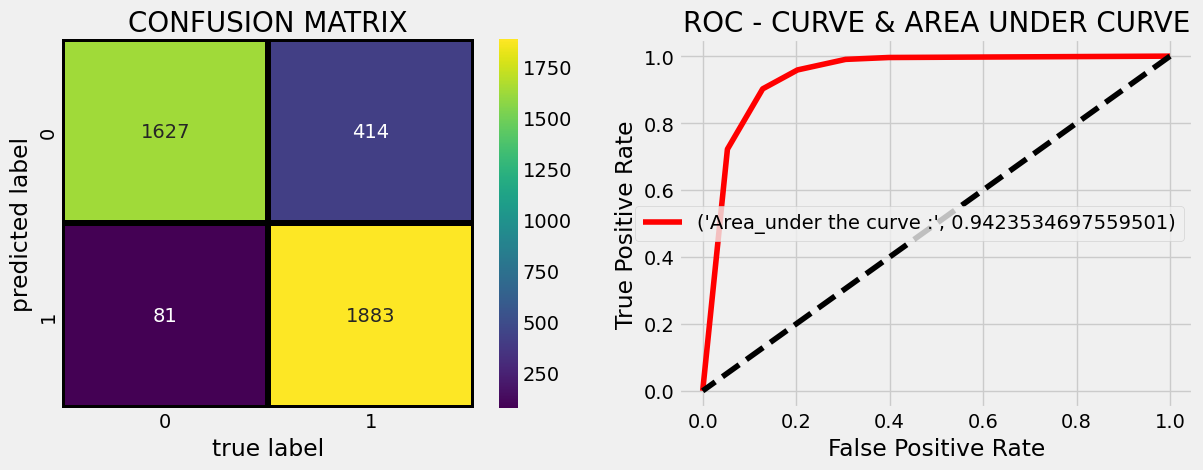

In [50]:
knn_model = KNeighborsClassifier()

knn_model.fit(train_X,train_y)

prediction=knn_model.predict(test_X)

print('Validation accuracy of KNN is', accuracy_score(prediction,test_y))
print ("\nClassification report :\n",(classification_report(test_y,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
plt.xlabel('true label')
plt.ylabel('predicted label')

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(test_X)[:,1]
fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

#save both figures
fig=plt.gcf()
fig.savefig('Figures\Fig16_exo_SMOTE_KNN_confusion_ROCcurve.png', bbox_inches='tight')

After applying Synthetic Minority Oversampling Technique (SMOTE), the KNN model performs much better.

# References

- [Kepler labelled time series data from Keggle](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?resource=download&select=exoTrain.csv)